## Apply a quadtree subdivision to the Vigilo observations of Brest

In [5]:
# Import necessary packages
import datetime  # For handling dates and times
import locale    # For setting the locale
import textwrap  # For wrapping text
import requests  # For making HTTP requests
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For creating plots
import seaborn as sns  # For improving the visual appearance of plots
import overpy  # For accessing OpenStreetMap data
import geopy.distance  # For calculating distances between two points
from scipy.spatial import Voronoi, voronoi_plot_2d  # For creating Voronoi diagrams
import numpy as np  # For numerical operations
import scipy.spatial as spatial  # For spatial operations
import matplotlib.path as path  # For creating paths in Matplotlib
import matplotlib as mpl  # For configuring Matplotlib
import smopy  # For dealing with OpenStreetMap tiles
import random  # For generating random numbers
import matplotlib.patches as patches  # For creating patches in Matplotlib
import warnings # For disabling future warnings



# Set the French locale for formatting dates
locale.setlocale(locale.LC_ALL, 'fr_FR.UTF-8')

# Set the seaborn style for better visual appearance of plots
sns.set_style("darkgrid")

# Set the seaborn context with a larger font size
sns.set_context("talk", font_scale=0.8)

# Define colors to be used in plots
blue, orange = sns.color_palette("muted", 2)

Lowered zoom level to keep map size reasonable. (z = 13)


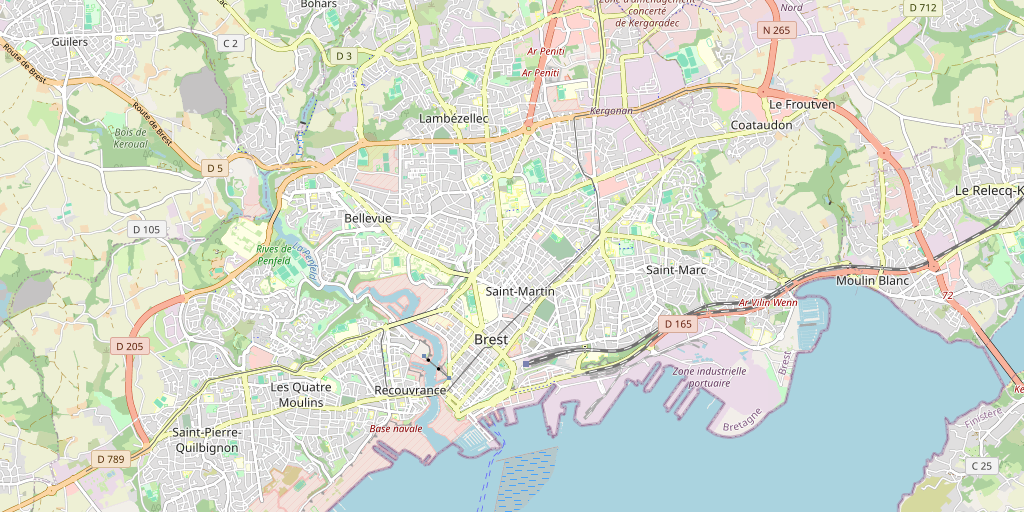

In [7]:
# Get and parse the data

# Suppressing the FutureWarning related to is_categorical_dtype
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Make an HTTP GET request to fetch data from a specified URL
    resp = requests.get('https://vigilo.bapav.org/get_issues.php') # vigilo database of BaPaV
    
    # Convert the JSON response to a DataFrame
    df = pd.DataFrame(resp.json())
    
    # Filter out rows where the 'comment' column is empty
    df = df[df.comment != '']
    
    # Convert the 'time' column to datetime format, assuming it's in seconds since epoch
    df.time = pd.to_datetime(df.time, unit='s')
    
    # Add a new column 'julian_day' representing the day of the year
    df['julian_day'] = df.time.apply(lambda x: x.timetuple().tm_yday)
    
    # Filter out data before January 1, 2020
    df = df[df.time.apply(lambda x: x.year) > 2019]
    
    # Sort the DataFrame by the 'time' column in ascending order
    df = df.sort_values(by='time', ascending=True)
    
    # Reset the index after sorting
    df = df.reset_index(drop=True)
    
    # Define a bounding box for the map around Brest
    box = (48.377, -4.556,
           48.416, -4.441)
    
    # Create a map using OpenStreetMap tiles within the specified bounding box at zoom level 20
    m = smopy.Map(box, z=20)
    
    # Show the map in the IPython environment
    m.show_ipython()

In [10]:
# Define the required classes and fonctions for defining the quadtree
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y    

class Node:
    def __init__(self, x0, y0, w, h, points):
        self.x0 = x0
        self.y0 = y0
        self.width = w
        self.height = h
        self.points = points
        self.children = []

    def get_width(self):
        return self.width
    
    def get_height(self):
        return self.height
    
    def get_points(self):
        return self.points  

def recursive_subdivide(node, k):
    if len(node.points) <= k:
        return

    w_ = float(node.width / 2)
    h_ = float(node.height / 2)

    x1 = Node(node.x0, node.y0, w_, h_, contains(node.x0, node.y0, w_, h_, node.points))
    recursive_subdivide(x1, k)

    x2 = Node(node.x0, node.y0 + h_, w_, h_, contains(node.x0, node.y0 + h_, w_, h_, node.points))
    recursive_subdivide(x2, k)

    x3 = Node(node.x0 + w_, node.y0, w_, h_, contains(node.x0 + w_, node.y0, w_, h_, node.points))
    recursive_subdivide(x3, k)

    x4 = Node(node.x0 + w_, node.y0 + h_, w_, h_, contains(node.x0 + w_, node.y0 + h_, w_, h_, node.points))
    recursive_subdivide(x4, k)

    node.children = [x1, x2, x3, x4]

def contains(x, y, w, h, points):
    pts = [point for point in points if x <= point.x <= x + w and y <= point.y <= y + h]
    return pts

def find_children(node):
    if not node.children:
        return [node]
    else:
        children = []
        for child in node.children:
            children += find_children(child)
    return children

def rectangulize(node):
    rec = np.array([(node.x0, node.y0),
                    (node.x0, node.y0 + node.height),
                    (node.x0 + node.width, node.y0 + node.height),
                    (node.x0 + node.width, node.y0)], dtype=np.float32)
    return rec

class QTree:
    def __init__(self, k, n, points, cells, m):
        self.threshold = k
        self.points = points
        
        # Create the root node for the Quadtree
        root_node = Node(48.377, -4.556, 0.039, 0.115, self.points)
        
        # Assign the root node to the 'root' attribute in the QTree instance
        self.root = root_node
        
        self.cells = cells
        self.m = m

    def add_point(self, x, y):
        self.points.append(Point(x, y))
    
    def get_points(self):
        return self.points
    
    def get_cells(self):
        return self.cells
    
    def subdivide(self):
        recursive_subdivide(self.root, self.threshold)
    
    def graph(self):
        c = find_children(self.root)
        print("Number of segments: %d" %len(c))
        areas = set()
        for el in c:
            areas.add(el.width * el.height)
        print("Minimum segment area: %.3f units" %min(areas))
        for n in c:
            self.cells.append(self.m.to_pixels(rectangulize(n)))
        return

In [12]:
# Convert all observations coordinates to points
points = []

# Iterate over the DataFrame rows to extract coordinates and create Point objects
for i in range(len(df.coordinates_lon)):
    # Extract latitude and longitude values from the DataFrame
    x = float(df.coordinates_lat.values[i])
    y = float(df.coordinates_lon.values[i])

    # Create a Point object and add it to the list
    points.append(Point(x, y))

In [26]:
# Define the threshold for Quadtree node subdivision
threshold_value = 30 # Number of observations per box

# Create a QTree instance with specified parameters, including the threshold
tree = QTree(threshold_value, len(points), points, [], m)

# Subdivide the Quadtree
tree.subdivide()

# Display information about the Quadtree
tree.graph()

# Retrieve the cells from the Quadtree
cells = tree.get_cells()

Number of segments: 58
Minimum segment area: 0.000 units


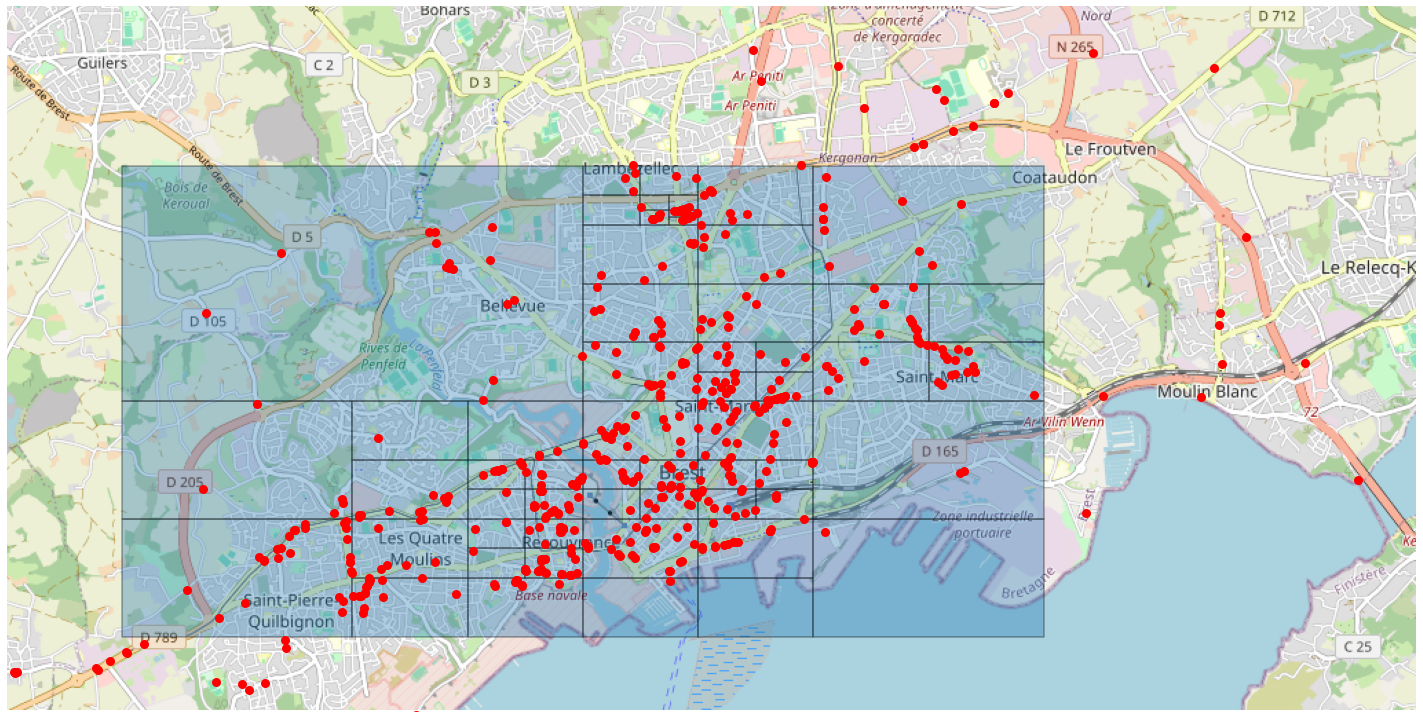

In [27]:
# Show the map using Matplotlib with specified figure size
ax = m.show_mpl(figsize=(20, 16))

# Add a PolyCollection to the map representing the Quadtree cells
ax.add_collection(
    mpl.collections.PolyCollection(
        cells,              # List of polygons representing Quadtree cells
        edgecolors='k',     # Edge color of the polygons
        alpha=0.35          # Transparency level of the polygons
    )
)

# Plot individual points on the map
for i in range(len(df.coordinates_lon)):
    # Extract latitude and longitude from the DataFrame
    x = float(df.coordinates_lat.values[i])
    y = float(df.coordinates_lon.values[i])

    # Convert geographical coordinates to pixels on the map
    xp, yp = m.to_pixels(x, y)

    # Plot the points on the map as red circles
    ax.plot(xp, yp, 'or', ms=7, mew=2)